In [142]:
import numpy as np
import matplotlib
from skimage.color import rgb2gray, rgba2rgb
import math

sector_size = 8
idx = 5

In [188]:
def imgAverage(img):
    average = 0
    height,width = img.shape
    for x in range(0, height):
        for y in range(0, width):
            average += img[x][y].imag
    average = average/2
    return average
    
def cAverage(cnum1,cnum2):
    res = complex(0,0)
    res = complex((cnum1.real + cnum2.real)/2, (cnum1.imag + cnum2.imag)/2)
    return res

def cAverageInSector(sector):
    average_real = 0
    average_imag = 0
    average = 0
    for x in range (0, sector_size):
        for y in range (0, sector_size):
            if(x != idx and y != idx):
                average_real += sector[x][y].real
                average_imag += sector[x][y].imag
                average = complex(average_real,average_imag)
    return average

def averageInSector(sector):
    average = 0
    for x in range (0, sector_size):
        for y in range (0, sector_size):
            if(x != idx and y != idx):
                average += sector[x][y].real
                average = complex(average, 0)
    return average

def toGrayScale(img):
    imgGray = img
    if(img.shape[2] == 4):
        imgGray = rgb2gray(rgba2rgb(img))
        return imgGray
    imgGray = rgb2gray(img)
    return imgGray

def applyFFT(img):
    imgFFT = np.fft.fftshift(np.fft.fft2(img))
    return imgFFT

def applyIFFT(img):
    imgIFFT = np.fft.ifft2(img)
    return imgIFFT

def encode(img1, img2):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    print(height,width)
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.ravel()
    ind = 0
    
    for x in range (0, height-sector_size, sector_size):
        for y in range (0, width-sector_size, sector_size):
            if ind < len(imgSecretFlat):
                subdct = imgBase[x:x+sector_size, y:y+sector_size]
                subdct[idx][idx] += imgSecretFlat[ind]
                imgBase[x:x+sector_size, y:y+sector_size] = subdct
                ind += 1
    imgBase = applyIFFT(imgBase)
    return imgBase    

In [191]:
imgBaseName = './images/girl.png'
imgSecretName = './images/test.png'

imgBase = plt.imread(imgBaseName)
#imgBase = imgBase[:,:,:3]*255
#imgBase = imgBase.astype(np.uint8)

imgBaseGray = toGrayScale(imgBase)
matplotlib.image.imsave('./images/pre.png', imgBaseGray)

imgSecret = plt.imread(imgSecretName)
imgSecretGray = toGrayScale(imgSecret)

512 512


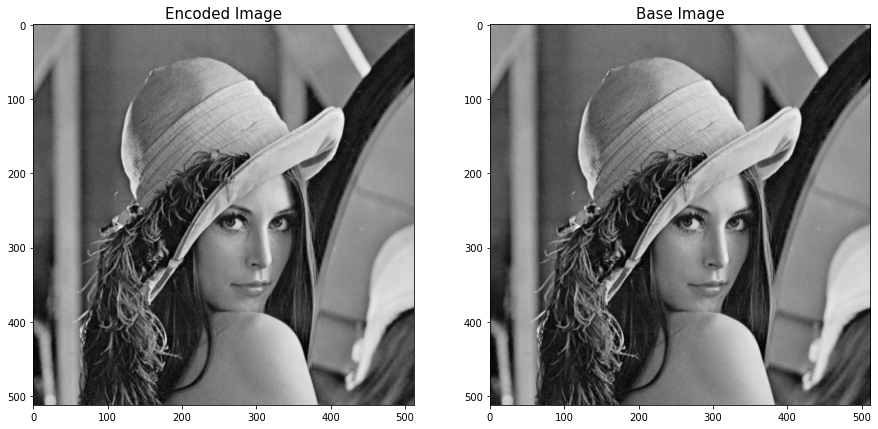

In [192]:
finalImage = encode(imgBaseGray, imgSecretGray)
matplotlib.image.imsave('./images/encoded.png', abs(finalImage))

fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].set_title('Encoded Image', fontsize = 15)
ax[0].imshow(abs(finalImage), cmap='gray')
    
ax[1].set_title('Base Image', fontsize = 15)
ax[1].imshow(imgBaseGray, cmap = 'gray')

In [360]:
#secret = decode(finalImage, imgSecretGray)
#plt.imshow(secret)
#finalImage = applyFFT(finalImage)
#plt.imshow(np.log(abs(finalImage)))